Epoch 1/10
261/261 [==============================] - 116s 387ms/step - loss: 0.3017 - accuracy: 0.8908 - precision: 0.9231 - recall: 0.9308 - val_loss: 5.4099 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 102s 389ms/step - loss: 0.1574 - accuracy: 0.9370 - precision: 0.9549 - recall: 0.9607 - val_loss: 0.4295 - val_accuracy: 0.8731 - val_precision: 0.8552 - val_recall: 0.9961
Epoch 3/10
261/261 [==============================] - 99s 381ms/step - loss: 0.1389 - accuracy: 0.9468 - precision: 0.9631 - recall: 0.9656 - val_loss: 0.5884 - val_accuracy: 0.7702 - val_precision: 0.7615 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 102s 392ms/step - loss: 0.1156 - accuracy: 0.9569 - precision: 0.9713 - recall: 0.9706 - val_loss: 0.1657 - val_accuracy: 0.9433 - val_precision: 0.9889 - val_recall: 0.9331
Epoch 5/10
261/261 [==============================] - 102s 391ms/step - loss: 0.1074 - ac

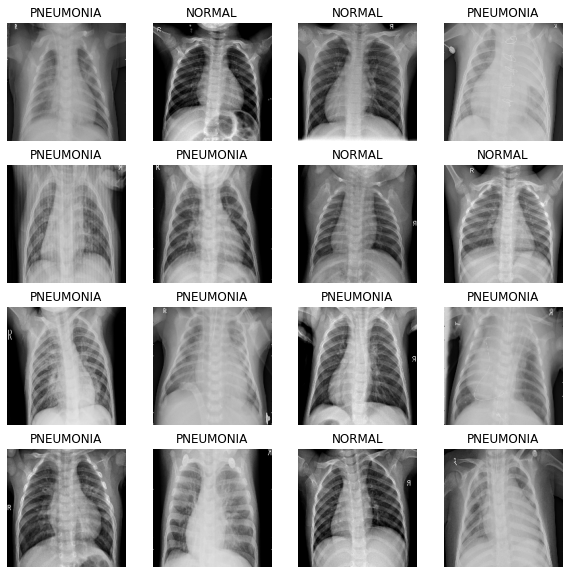

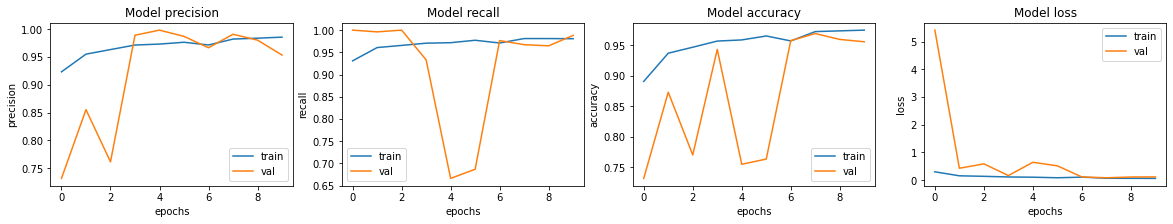

In [3]:
import os
import re
import random
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense

# 경고 메시지 숨기기
# warnings.filterwarnings(action='ignore')

# 상수 및 경로 정의
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'
BATCH_SIZE = 16
EPOCHS = 10

# 데이터 경로 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 데이터셋 분리
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))
train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 클래스 별 이미지 개수 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# 데이터셋 구성 및 크기 확인
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# 이미지 로드 및 전처리 함수 정의
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

def decode_img(img):
    # 이미지 디코딩 및 정규화
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    # 이미지 로드 및 레이블 설정
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# 데이터셋 구성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 테스트 데이터셋 구성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 데이터 증강 및 전처리 함수 정의
def augment(image, label):
    # 이미지를 좌우로 무작위로 뒤집음
    image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 데이터 증강 및 셔플링 적용
    ds = ds.map(
        augment,
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# 데이터셋에 증강 및 전처리 적용
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 이미지 배치 시각화 함수 정의
def show_batch(image_batch, label_batch):
    # 이미지 배치 시각화
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# 한 배치의 이미지 출력
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# ResNet18 모델 정의
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # 첫 번째 convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 두 번째 convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # 만약 차원이 맞지 않는다면 shortcut을 조절
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # Residual connection
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

def build_resnet18(input_shape=(180, 180, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    
    # Initial convolution layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    
    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    x = Dense(num_classes, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

# 모델 생성
with tf.device('/GPU:0'):
    resnet18_model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    resnet18_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

# 모델 훈련
with tf.device('/GPU:0'):
    history_resnet18 = resnet18_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

# 훈련 과정 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_resnet18.history[met])
    ax[i].plot(history_resnet18.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 모델 평가
loss, accuracy, precision, recall = resnet18_model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')


In [ ]:
'''
흉부 X-RAY 이미지 분류 딥러닝 모델 구축 및 학습 보고서

프로젝트를 진행하면서 흉부 X-RAY 이미지를 분류하는 딥러닝 모델을 구축하고 훈련시키는 과정을 기록하였습니다. 
초보자 관점에서 따라갈 수 있도록 주석과 간단한 설명을 포함하여 작성되었습니다. 
과제 목적은 ResNet18 아키텍처를 사용하여 폐렴 여부를 감지하는 것이었습니다. 
아래에서는 주요 목차 및 코드에 대한 주석, 회고록, 그리고 참고 자료 등에 대한 내용을 기술하였습니다.


A. 목차


1. 준비 단계
    1.1 라이브러리 및 패키지 임포트
    
    import os
    import re
    import random
    import math
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense

    1.2 상수 및 경로 정의
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    IMAGE_SIZE = [180, 180]
    ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
    TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
    VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
    TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'
    BATCH_SIZE = 16
    EPOCHS = 10
    
    데이터셋 로딩 및 분할
    
    train_filenames = tf.io.gfile.glob(TRAIN_PATH)
    test_filenames = tf.io.gfile.glob(TEST_PATH)
    val_filenames = tf.io.gfile.glob(VAL_PATH)

    데이터셋 분리
    filenames = tf.io.gfile.glob(TRAIN_PATH)
    filenames.extend(tf.io.gfile.glob(VAL_PATH))
    train_size = math.floor(len(filenames) * 0.8)
    random.seed(8)
    random.shuffle(filenames)
    train_filenames = filenames[:train_size]
    val_filenames = filenames[train_size:]

2. 데이터 전처리
    2.1 이미지 로드 및 레이블 설정

    def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

    def decode_img(img):
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, IMAGE_SIZE)
        return img

    def process_path(file_path):
        label = get_label(file_path)
        img = tf.io.read_file(file_path)
        img = decode_img(img)
        return img, label

    
    2.2 데이터 증강 및 전처리 함수 정의
    
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        return image, label

    def prepare_for_training(ds, shuffle_buffer_size=1000):
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

    2.3 훈련, 검증, 테스트 데이터셋 구성
    
    # 데이터셋 구성
    train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    # 테스트 데이터셋 구성
    test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
    TEST_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
    test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)

    

3. 데이터 시각화
    3.1 이미지 배치 시각화 함수 정의
    
    def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

    
    3.2 훈련 데이터셋 이미지 시각화
    
    # 한 배치의 이미지 출력
    image_batch, label_batch = next(iter(train_ds))
    show_batch(image_batch.numpy(), label_batch.numpy())


4. ResNet18 모델 구축
    Residual 블록 및 ResNet18 모델 함수 정의
    
5.모델 컴파일 및 훈련
    모델 컴파일 및 클래스 가중치 설정
    모델 훈련 및 과정 시각화

6. 모델 평가
    테스트 데이터셋을 사용한 모델 평가

7. SUMMARY 및 회고

    간략한 프로젝트 요약
    회고록
    

B. SUMMARY

이 프로젝트에서는 TensorFlow와 Keras를 사용하여 흉부 X-RAY 이미지를 분류하는 딥러닝 모델을 구축해 보았습니다.
데이터 전처리, 데이터 증강, ResNet18 모델의 구축, 모델 훈련 및 평가 등의 단계를 통해 폐렴 여부를 감지하는 모델을 
학습을 시켜보았습니다. 좀 더 나은 모델의 성능을 만들기 위해서 고민해 봐야하는 것들을 경험하는 계기가 되었던 것
같았습니다.


C. 모델 설계 구조

참고로 아래는 흉부 X-RAY 이미지 분류를 위한 ResNet18 모델의 설계 구조를 도식화한 것입니다.


Input: (180, 180, 3)

├─ Conv2D (64, kernel=7, stride=2, padding='same')
├─ BatchNormalization
├─ ReLU
├─ MaxPooling2D (pool_size=3, stride=2, padding='same')

├─ Residual Block 1
│   ├─ Conv2D (64, kernel=3, stride=1, padding='same')
│   ├─ BatchNormalization
│   ├─ ReLU
│   ├─ Conv2D (64, kernel=3, stride=1, padding='same')
│   ├─ BatchNormalization
│   └─ Add (Residual Connection)
│       ├─ Conv2D (64, kernel=1, stride=1, padding='same')
│       ├─ BatchNormalization

├─ Residual Block 2
│   ├─ Conv2D (128, kernel=3, stride=2, padding='same')
│   ├─ BatchNormalization
│   ├─ ReLU
│   ├─ Conv2D (128, kernel=3, stride=1, padding='same')
│   ├─ BatchNormalization
│   └─ Add (Residual Connection)
│       ├─ Conv2D (128, kernel=1, stride=2, padding='same')
│       ├─ BatchNormalization

├─ Residual Block 3
│   ├─ Conv2D (256, kernel=3, stride=2, padding='same')
│   ├─ BatchNormalization
│   ├─ ReLU
│   ├─ Conv2D (256, kernel=3, stride=1, padding='same')
│   ├─ BatchNormalization
│   └─ Add (Residual Connection)
│       ├─ Conv2D (256, kernel=1, stride=2, padding='same')
│       ├─ BatchNormalization

├─ Residual Block 4
│   ├─ Conv2D (512, kernel=3, stride=2, padding='same')
│   ├─ BatchNormalization
│   ├─ ReLU
│   ├─ Conv2D (512, kernel=3, stride=1, padding='same')
│   ├─ BatchNormalization
│   └─ Add (Residual Connection)
│       ├─ Conv2D (512, kernel=1, stride=2, padding='same')
│       ├─ BatchNormalization

├─ GlobalAveragePooling2D

└─ Dense (1, activation='sigmoid')


설명:

    Conv2D: 2D 합성곱 레이어로, 이미지의 특징을 추출합니다.
    BatchNormalization: 레이어의 입력을 정규화하여 학습을 안정화시킵니다.
    ReLU: 활성화 함수로, 음수 값을 제거하고 양수 값을 전달합니다.
    MaxPooling2D: 최대 풀링 레이어로, 공간 차원을 줄입니다.
    Residual Block: 잔차 연결을 사용하여 그래디언트 손실을 방지하는 블록입니다.
    GlobalAveragePooling2D: 공간 차원을 평균화하여 고정된 크기의 출력을 생성합니다.
    Dense: 밀집 연결 레이어로, 분류를 수행합니다.
    이 구조를 바탕으로 ResNet18 모델이 훈련됩니다.
    

D. 회고록

이 프로젝트를 통해 딥러닝 모델을 구축하는 전반적인 프로세스를 경험할 수 있었습니다. 
특히, 데이터 전처리와 데이터 증강의 중요성, ResNet18 아키텍처의 이해, 그리고 모델 평가 방법에 대해 학습하였습니다. 
주석을 통해 코드를 따라가는 것이 수월하도록 노력하였고,훈련된 모델의 결과를 확인하는 것이 흥미로웠습니다.


이번 프로젝트를 통해 딥러닝 모델을 구축하는 전반적인 프로세스를 경험하면서, 주로 데이터 전처리와 데이터 증강의 중요성을
몸소 체험할 수 있었습니다.
특히, 의료 분야에서 모델을 평가하고 개선하기 위해서는 높은 정확성 뿐만 아니라 민감도(Recall)가 중요하다는 것도 배웠습니다. 
ResNet18 아키텍처의 이해와 그 활용은 이미지 분류 과제에 대한 효과적인 해결책을 찾는 데 도움이 된 것 같았습니다.
주석을 통해 코드를 따라가는 것이 수월하도록 노력하였으며, 모델을 훈련하고 결과를 확인하는 과정과 시작적으로 결과가
도출될 때 흥미로움을 느낄 수 있었습니다. 
이를 통해 딥러닝 모델을 실제 상황에 적용하는 데 있어서 어떤 어려움이 있을지 예측하고 대응하는 능력을 미리 길러볼 수 있었던
좋은 계기가 된 것 같았습니다.

감사합니다.

PS. 참고로 실습하기 노드도 파일 따로 같이 올려놓았습니다.

--> 파일명 :[Main Quest 04] 폐렴아 기다려라! [프로젝트 제출]

'''